In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/34 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N20.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N1.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/49 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N15.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/No18.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/31 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 6.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/3 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 5.jpeg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 1.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/26 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N26.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N5.jpg
/kaggle/input/brain-mri-images-for-b

In [2]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split


from tensorflow.keras.applications import VGG19,VGG16,Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout


2024-04-26 19:15:24.763899: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 19:15:24.764031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 19:15:24.903767: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
no_dir='/kaggle/input/brain-mri-images-for-brain-tumor-detection/no'
yes_dir='/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes'

In [4]:
def create_class_dataframe(class_dir, class_name):
    files = os.listdir(class_dir)
    image_files = [file for file in files if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))]
    data = {'image_path': [os.path.join(class_dir, file) for file in image_files],
            'label': [class_name] * len(image_files)}
    return pd.DataFrame(data)

In [5]:
no_df=create_class_dataframe(no_dir, '0')
yes_df=create_class_dataframe(yes_dir, '1')

In [6]:
df = pd.concat([no_df,yes_df], ignore_index=True)

In [7]:
def shuffle_dataframe(df):
    shuffled_df = df.sample(frac=1).reset_index(drop=True)
    return shuffled_df

df=shuffle_dataframe(df)

In [8]:
df.head()

,image_path,label
0,/kaggle/input/brain-mri-images-for-brain-tumor...,0
1,/kaggle/input/brain-mri-images-for-brain-tumor...,1
2,/kaggle/input/brain-mri-images-for-brain-tumor...,0
3,/kaggle/input/brain-mri-images-for-brain-tumor...,1
4,/kaggle/input/brain-mri-images-for-brain-tumor...,1


In [9]:
df.label.value_counts()

label
1    155
0     98
Name: count, dtype: int64

<Axes: xlabel='label'>

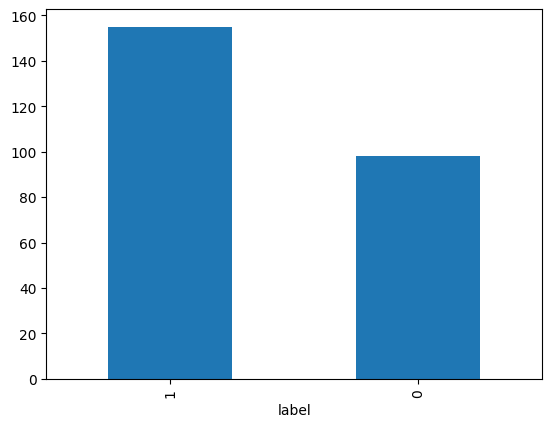

In [10]:
df.label.value_counts().plot(kind='bar')

In [11]:
def print_class_proportions(labels):
    # Count the occurrences of each class label
    class_counts = labels.value_counts()
    
    # Calculate proportions
    total_samples = len(labels)
    class_proportions = class_counts / total_samples
    
    # Print class proportions
    print("Class Proportions:")
    for class_label, proportion in class_proportions.items():
        print(f"Class {class_label}: {proportion:.2%}")

# Example usage:
# Assuming 'labels' is a Pandas Series containing class 

print_class_proportions(df['label'])

Class Proportions:
Class 1: 61.26%
Class 0: 38.74%


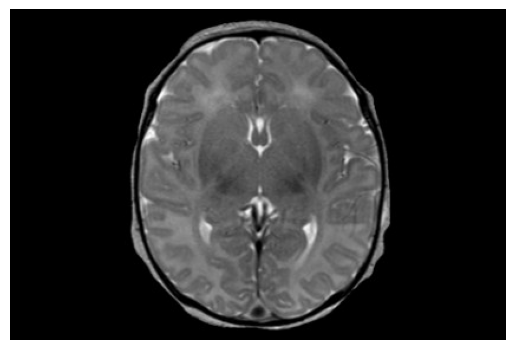

In [12]:
#img=cv2.imread(df['Image_Path'].values[0])
img = mpimg.imread(df['image_path'].values[0])

plt.imshow(img)
plt.axis('off')  
plt.show()

In [13]:

def is_grayscale(image_path):
    # Read the image
    image = cv2.imread(image_path)

    # Check if image is None
    if image is None:
        print("Error: Unable to read the image.")
        return False

    # Get the number of channels in the image
    num_channels = image.shape[2] if len(image.shape) == 3 else 1

    # Return True if the image has only 1 channel (grayscale), False otherwise
    return num_channels == 1

# Example usage
image_path = df['image_path'].values[0]
if is_grayscale(image_path):
    print("The image is grayscale.")
else:
    print("The image is RGB.")


The image is RGB.


In [14]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns

def evaluate_classification(y_true, y_pred, classes):
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate precision, recall, and F1-score
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)


# test

In [15]:
df_0=df.query('label=="0"').iloc[:10,:]
df_1=df.query('label=="1"').iloc[:20,:]


df_test = pd.concat([df_0,df_1], ignore_index=True)


In [16]:
df_test=shuffle_dataframe(df_test)
df_test.head()

,image_path,label
0,/kaggle/input/brain-mri-images-for-brain-tumor...,1
1,/kaggle/input/brain-mri-images-for-brain-tumor...,1
2,/kaggle/input/brain-mri-images-for-brain-tumor...,1
3,/kaggle/input/brain-mri-images-for-brain-tumor...,0
4,/kaggle/input/brain-mri-images-for-brain-tumor...,1


In [17]:
df_test.shape

(30, 2)

In [18]:

# Merge the DataFrames with indicator
merged_df = df.merge(df_test, how='outer', indicator=True)

# Keep only the records that exist in df1 but not in df2
result_df = merged_df[merged_df['_merge'] == 'left_only']

# Drop the '_merge' column if needed
result_df = result_df.drop(columns=['_merge'])

print(result_df.shape)


(223, 2)


In [19]:
result_df.shape,df.shape,df_test.shape

((223, 2), (253, 2), (30, 2))

In [20]:
result_df=shuffle_dataframe(result_df)
result_df.head()

,image_path,label
0,/kaggle/input/brain-mri-images-for-brain-tumor...,1
1,/kaggle/input/brain-mri-images-for-brain-tumor...,0
2,/kaggle/input/brain-mri-images-for-brain-tumor...,0
3,/kaggle/input/brain-mri-images-for-brain-tumor...,0
4,/kaggle/input/brain-mri-images-for-brain-tumor...,1


In [21]:
result_df.head()

,image_path,label
0,/kaggle/input/brain-mri-images-for-brain-tumor...,1
1,/kaggle/input/brain-mri-images-for-brain-tumor...,0
2,/kaggle/input/brain-mri-images-for-brain-tumor...,0
3,/kaggle/input/brain-mri-images-for-brain-tumor...,0
4,/kaggle/input/brain-mri-images-for-brain-tumor...,1


In [22]:
def preprocess_image(image_path, target_size=(224, 224), grayscale=False):
    
    image = cv2.resize(image_path, target_size)
    
    if grayscale:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    image = image.astype('float32') / 255.0
    
    return image

def load_and_preprocess_images(image_series, label_series):
    images = []
    labels = []

    for img_path, label in zip(image_series, label_series):
        img = cv2.imread(img_path)
        img = preprocess_image(img)
        images.append(img)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

In [23]:
test_image,test_label=load_and_preprocess_images(df_test['image_path'], df_test['label'])

# Augmentation

In [24]:
train_df, valid_df = train_test_split(result_df, stratify=result_df['label'],test_size=0.2, random_state=42)


In [25]:

datagen = ImageDataGenerator(
    rotation_range=30,  
    shear_range=0.2,  
    zoom_range=0.1,  
    horizontal_flip=True,
        vertical_flip=True,
    #brightness_range=[0.4,0.6],
     
        rescale=1.0/255,

    
    fill_mode='nearest'  # Strategy used for filling in newly created pixels
)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
   target_size=(224, 224),
    batch_size=64,
     color_mode="rgb",
    class_mode='binary'
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
     color_mode="rgb",
    class_mode='binary'
)


Found 178 validated image filenames belonging to 2 classes.
Found 45 validated image filenames belonging to 2 classes.


# model

In [26]:
batch_size=8
epochs=30

In [27]:
import tensorflow as tf
import keras_cv
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Check and set GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

In [28]:
input_shape=(224,224,3)


In [29]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(128, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        #Dropout(.2),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        # Dropout(.2),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        
        
        #Dropout(.2),
         #Dense(64, activation='relu'), 
         #Dropout(.2),
        Dense(16, activation='relu'),
      #Dropout(0.2),
        Dense(num_classes, activation='sigmoid')
    ])
    
    return model


In [30]:
model=create_cnn_model((224,224,3),1)
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/22 ━━━━━━━━━━━━━━━━━━━━ 7:04 20s/step - accuracy: 0.5938 - loss: 0.6888

I0000 00:00:1714158967.957937      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 3/22 ━━━━━━━━━━━━━━━━━━━━ 1:45 6s/step - accuracy: 0.5976 - loss: 0.7308 

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


22/22 ━━━━━━━━━━━━━━━━━━━━ 37s 791ms/step - accuracy: 0.5715 - loss: 0.7379 - val_accuracy: 0.4000 - val_loss: 0.7867
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.4690 - loss: 0.7322 - val_accuracy: 0.6000 - val_loss: 0.6534
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.6095 - loss: 0.6568 - val_accuracy: 0.6000 - val_loss: 0.6510
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.6523 - loss: 0.6037 - val_accuracy: 0.6444 - val_loss: 0.6033
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.7048 - loss: 0.5830 - val_accuracy: 0.6444 - val_loss: 0.6269
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.7329 - loss: 0.5452 - val_accuracy: 0.7111 - val_loss: 0.5688
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.7187 - loss: 0.5708 - val_accuracy: 0.7333 - val_loss: 0.6469
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.7064 - loss: 0.5992 - val_accuracy: 0.7111 - val_loss: 

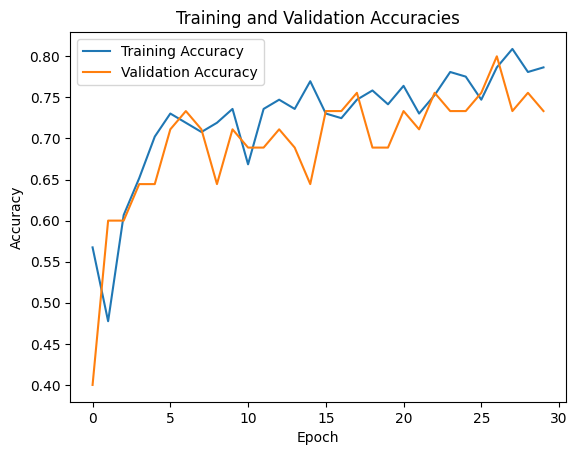

In [31]:
history = model.fit(
    train_generator,
    batch_size=batch_size,    epochs=epochs,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples //batch_size)
         #,callbacks=[early_stopping])

# Optionally, you can plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.5095 - loss: 1.8237 - val_accuracy: 0.6000 - val_loss: 3.3348
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6787 - loss: 2.0906 - val_accuracy: 0.6444 - val_loss: 1.8812
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5821 - loss: 2.3752 - val_accuracy: 0.7556 - val_loss: 1.3657
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.7642 - loss: 1.4259 - val_accuracy: 0.7778 - val_loss: 0.7446
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.7565 - loss: 1.0951 - val_accuracy: 0.8222 - val_loss: 0.8051
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8244 - loss: 0.9477 - val_accuracy: 0.8000 - val_loss: 1.0268
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8372 - loss: 0.6334 - val_accuracy: 0.8222 - val_loss: 0.4996
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy

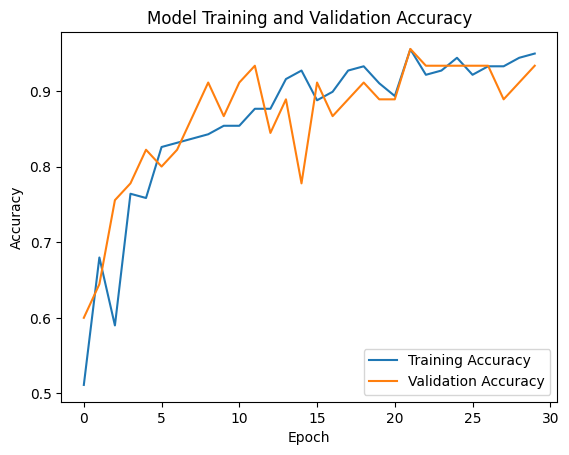

In [32]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False
# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(64, activation='relu')(x)
x = Dropout(.2)(x)

x = Dense(64, activation='relu')(x)
#x = Dropout(.2)(x)

#x = Dense(32, activation='relu')(x)
#x = Dropout(.2)(x)

#x = Dense(16, activation='relu')(x)
#x = Dense(8, activation='relu')(x)

predictions = Dense(1, activation='sigmoid')(x)
# Create final model
model_Xception = Model(inputs=base_model.input, outputs=predictions)
# Compile the model
model_Xception.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_Xception.fit(train_generator, 
                       steps_per_epoch=train_generator.samples // batch_size,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=valid_generator,
                      validation_steps=valid_generator.samples //batch_size)
                     #  ,callbacks=[early_stopping])
# Plot training and validation accuracies
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Training and Validation Accuracy')
plt.legend()
plt.show()

In [33]:
loss,acc=model_Xception.evaluate(test_image,test_label.astype('int'))
loss,acc

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.8333 - loss: 0.4643


(0.4643235504627228, 0.8333333134651184)

In [34]:
model_Xception.save('brain_tumor.h5')

In [35]:
model_Xception.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 40,141,933 (153.13 MB)

 Trainable params: 6,426,817 (24.52 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

 Optimizer params: 12,853,636 (49.03 MB)

In [36]:
#!git clone https://github.com/RagabHassan1/tantawy_project_final.git

In [37]:
#!mv /kaggle/working/brain_tumor.h5 /kaggle/working/tantawy_project_final

In [38]:
#!git add /kaggle/working/tantawy_project_final/brain_tumor.h5


In [39]:
#%cd tantawy_project_final/

In [40]:
#!pwd

In [41]:
#! git add brain_tumor.h5

In [42]:
#!git commit -m "Added Keras brain_tumor.h5"


In [43]:
#!git push

In [44]:
#!git config --global user.email "ragabhassan716@gmail.com"

In [45]:
#!pwd

In [46]:
#!git remote add origin https://github.com/RagabHassan1/tantawy_project_final.git


In [47]:

#!git  config --global user.name "RagabHassan1" 
#! git push origin main

In [48]:
! git push origin main

fatal: not a git repository (or any parent up to mount point /kaggle)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
